In [13]:
!pip install -r ../src/requirements.txt

# Aquisição de dados
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

df = pd.read_csv("../data/01_raw/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Pré Processamento
---

In [2]:
df.isna().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [3]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [4]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [5]:
label_df = df["Survived"]

feat_cols = df.columns
feat_cols = feat_cols.drop(["Survived","Name","Ticket","Cabin"])

features_df = df[feat_cols]
features_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_df, label_df, 
                                                    test_size=0.33, random_state=42)

In [7]:
from sklearn.preprocessing import LabelEncoder

category_cols = ["Sex", "Embarked"]

# Label encode categorical features
le = {}
for col in category_cols:
    le[col] = LabelEncoder()
    X_train[col] = le[col].fit_transform(X_train[col])

c:\users\lucas\anaconda3\envs\titanic\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
X_train.fillna(0.0, inplace=True)

c:\users\lucas\anaconda3\envs\titanic\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [18]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)

In [19]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_, y_ = oversample.fit_resample(X_train, y_train)

### Dados de entrada

In [20]:
import pickle

with open('../data/05_model_input/input_data_exp1.pkl', 'wb') as handle:
    pickle.dump({'X': X_, 'y': y_}, handle)

# Criação do Modelo
---

In [21]:
with open('../data/05_model_input/input_data_exp1.pkl', 'rb') as handle:
    input_data = pickle.load(handle)
    
X, y = input_data['X'], input_data['y']

In [22]:
import xgboost as xgb

clf = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=15
)
clf.fit(X, y)

c:\users\lucas\anaconda3\envs\titanic\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:59:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Salvando os modelos

In [23]:
import pickle

with open("../data/06_models/model.pkl", "wb") as handle:
    pickle.dump({"model": clf, "se": ss, "le":le}, handle)

# Validação do Modelo
---

In [24]:
with open("../data/06_models/model.pkl", "rb") as handle:
    data = pickle.load(handle)

In [25]:
for col in category_cols:
    X_test[col] = le[col].transform(X_test[col])
X_test.fillna(0.0, inplace=True)
X_test = ss.transform(X_test)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

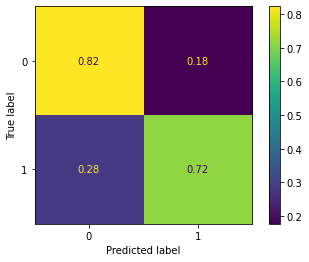

In [26]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, normalize="true")
plt.show()